<a href="https://colab.research.google.com/github/atabakjd/JSE-Stock-Market-Returns-Prediction-Using-Multivariate-Time-Series-Data/blob/main/crypto_mvgruReg_yfinance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

this code has a good point about multi layer rnns in keras, whitch is written in 'design network' part. that is adding "return_sequences = True" in properties of first rnn layer.
checkpoint is used correctly

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install yfinance
!pip install yahoofinancials

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import yfinance as yf
import yahoofinancials
from math import sqrt
import numpy
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import sklearn
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint
# from tensorflow.keras.callbacks import ModelCheckpoint
from pandas import read_csv
from datetime import datetime
from google.colab import files

In [4]:
data=yf.download('BTC-USD', start="2019-07-10", interval= "1d")
print(data.head())

[*********************100%***********************]  1 of 1 completed
                    Open          High           Low         Close  \
Date                                                                 
2019-07-10  12571.537109  13129.529297  11710.978516  12156.512695   
2019-07-11  12139.713867  12144.623047  11158.922852  11358.662109   
2019-07-12  11354.299805  11905.487305  11179.144531  11815.986328   
2019-07-13  11813.126953  11841.957031  10908.479492  11392.378906   
2019-07-14  11381.020508  11451.204102  10234.576172  10256.058594   

               Adj Close       Volume  
Date                                   
2019-07-10  12156.512695  33627574244  
2019-07-11  11358.662109  28595327690  
2019-07-12  11815.986328  23534692797  
2019-07-13  11392.378906  21042616384  
2019-07-14  10256.058594  22486000001  


1157


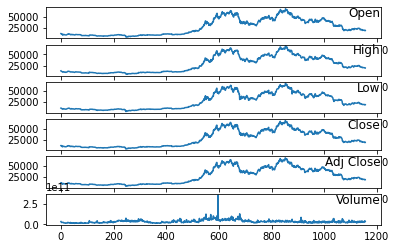

In [5]:
# path="/content/drive/MyDrive/ETH-USD.csv"
dataset = data
values = dataset.values
n_values=len(values)
print(n_values)
# specify columns to plot
groups = [0, 1, 2, 3, 4, 5]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

In [6]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
#load dataset
#dataset = read_csv(path, header=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,2] = encoder.fit_transform(values[:,2])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)   var1(t)  \
1   0.121012   0.122880   0.401384   0.114795   0.114795   0.065334  0.114108   
2   0.114108   0.107359   0.363322   0.102049   0.102049   0.050512  0.101551   
3   0.101551   0.103591   0.364187   0.109355   0.109355   0.035607  0.108887   
4   0.108887   0.102590   0.355536   0.102588   0.102588   0.028267  0.101978   
5   0.101978   0.096432   0.316609   0.084435   0.084435   0.032518  0.084021   

    var2(t)   var3(t)   var4(t)   var5(t)   var6(t)  
1  0.107359  0.363322  0.102049  0.102049  0.050512  
2  0.103591  0.364187  0.109355  0.109355  0.035607  
3  0.102590  0.355536  0.102588  0.102588  0.028267  
4  0.096432  0.316609  0.084435  0.084435  0.032518  
5  0.090153  0.290657  0.094643  0.094643  0.041054  


In [18]:
# scaler=MinMaxScaler(feature_range=(0,1))
# values=scaler.fit_transform(values)

In [7]:
# split into train and test sets
values = reframed.values
random.shuffle(values)
n_train =int(0.9*(n_values)) 
#sklearn.model_selection.train_test_split(values, train_size=n_train, test_size=16000)
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, (0,1,2,3,5)], train[:, 4]
test_X, test_y = test[:, (0,1,2,3,5)], test[:, 4]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1041, 1, 5) (1041,) (115, 1, 5) (115,)


Epoch 1/100
33/33 - 8s - loss: 0.0275 - mse: 0.0275 - val_loss: 0.1343 - val_mse: 0.1343 - 8s/epoch - 240ms/step
Epoch 2/100
33/33 - 0s - loss: 0.0142 - mse: 0.0142 - val_loss: 0.1196 - val_mse: 0.1196 - 251ms/epoch - 8ms/step
Epoch 3/100
33/33 - 0s - loss: 0.0090 - mse: 0.0090 - val_loss: 0.1060 - val_mse: 0.1060 - 210ms/epoch - 6ms/step
Epoch 4/100
33/33 - 0s - loss: 0.0054 - mse: 0.0054 - val_loss: 0.0934 - val_mse: 0.0934 - 229ms/epoch - 7ms/step
Epoch 5/100
33/33 - 0s - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0846 - val_mse: 0.0846 - 241ms/epoch - 7ms/step
Epoch 6/100
33/33 - 0s - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0788 - val_mse: 0.0788 - 218ms/epoch - 7ms/step
Epoch 7/100
33/33 - 0s - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0724 - val_mse: 0.0724 - 221ms/epoch - 7ms/step
Epoch 8/100
33/33 - 0s - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0675 - val_mse: 0.0675 - 247ms/epoch - 7ms/step
Epoch 9/100
33/33 - 0s - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0619 - val_mse: 0.0619 

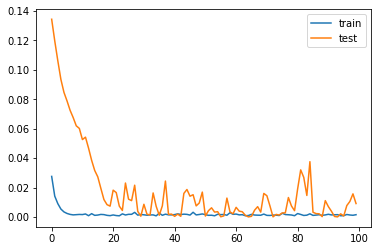

In [15]:
# design network
model = Sequential()
model.add(GRU(100, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences = True))
model.add(GRU(40))
model.add(Dense(1))
model.add(BatchNormalization())
model.compile(loss='mse', metrics='mse', optimizer='adam')
#checkpoint
# filepath="/content/drive/MyDrive/weights.h5"
# checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
# callbacks_list = [checkpoint]
checkpoint_filepath = "/content/drive/MyDrive/weights"
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='mse',
    mode='min',
    save_best_only=True)

# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=32, validation_data=(test_X, test_y), verbose=2, shuffle=True, callbacks=[model_checkpoint_callback])

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [16]:
model.load_weights(checkpoint_filepath)
evaluation = model.evaluate(test_X, test_y)
print(evaluation)

4/4 [==============================] - 0s 5ms/step - loss: 0.0072 - mse: 0.0072
[0.007163904141634703, 0.007163904141634703]


[[ 5.64142048e-01]
 [ 4.01073694e-01]
 [-6.01950288e-02]
 [ 2.98338205e-01]
 [ 1.08206272e-02]
 [-9.12550092e-03]
 [ 6.13086700e-01]
 [ 4.80739474e-02]
 [-5.78272045e-02]
 [ 8.14477265e-01]
 [ 3.37526858e-01]
 [ 2.90655792e-02]
 [ 5.85967302e-02]
 [ 6.74623251e-03]
 [-1.93960965e-02]
 [ 5.02517521e-01]
 [-4.59934473e-02]
 [ 9.90089029e-02]
 [ 2.92313397e-02]
 [-4.85875905e-02]
 [-5.25820255e-03]
 [ 2.32013464e-02]
 [ 7.32923508e-01]
 [ 2.97403097e-01]
 [ 3.30787957e-01]
 [ 5.82704544e-01]
 [ 6.34040236e-01]
 [-3.40135992e-02]
 [ 3.45563978e-01]
 [-5.96556067e-02]
 [-9.12550092e-03]
 [ 4.19975877e-01]
 [ 2.23609507e-02]
 [-1.84130073e-02]
 [ 2.86019176e-01]
 [ 8.09271336e-01]
 [ 4.65533018e-01]
 [ 4.86702263e-01]
 [-1.76648498e-02]
 [-5.48472404e-02]
 [-4.06998396e-03]
 [ 3.51659387e-01]
 [ 2.70047724e-01]
 [-4.78714705e-04]
 [ 4.71018910e-01]
 [ 5.84003031e-01]
 [ 4.57162768e-01]
 [ 4.26894665e-01]
 [-4.66213524e-02]
 [-7.07182288e-03]
 [-5.27136624e-02]
 [ 5.93620420e-01]
 [-4.6470642

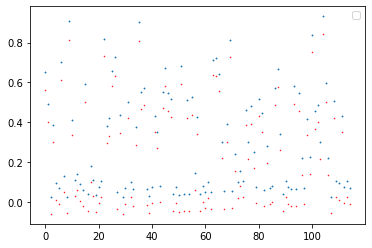

Test RMSE: 0.085


In [17]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
# inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# # invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
# inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# # calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
#pyplot.plot(test_y)
#pyplot.plot(yhat)
pyplot.scatter(numpy.arange(len(test_y)), test_y, marker='*',s=1)
pyplot.scatter(numpy.arange(len(test_y)), yhat, marker='.',s=1, color="red")
print(yhat)
path2="/content/drive/MyDrive/output3.csv"
path3="/content/drive/MyDrive/y_real.csv"
numpy.savetxt(path2, yhat)
numpy.savetxt(path3, test_y)
#yhat.to_csv('output2.csv')
#yhat.to_csv(brandname + 'yhat.csv', sep='\t')
#files.download(brandname + 'yhat.csv')
pyplot.legend()
pyplot.show()
print('Test RMSE: %.3f' % rmse)

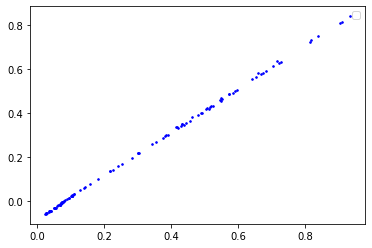

In [18]:
pyplot.scatter(test_y, yhat, color='blue', marker='.', s=10)
pyplot.legend()
pyplot.show()
